In [1]:
!pip install numpy pandas matplotlib tensorflow scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
feature_prediction = 'Open'

In [25]:
df = pd.read_csv('/content/drive/My Drive/IGP Notebooks/Prepared Data/MSFT/MSFT_stock_data_2020-01-01_to_2023-12-31.csv')

close_prices = df[feature_prediction].values.reshape(-1, 1)

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(close_prices)

In [27]:
split_point = int(len(data_normalized) * 0.8)
train, test = data_normalized[:split_point, :], data_normalized[split_point:, :]

In [28]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3  # Number of days the model will look back
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape input [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [29]:
model = Sequential([
    LSTM(50, input_shape=(1, look_back)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
800/800 - 4s - loss: 0.0101 - 4s/epoch - 5ms/step
Epoch 2/100
800/800 - 2s - loss: 6.5728e-04 - 2s/epoch - 3ms/step
Epoch 3/100
800/800 - 3s - loss: 6.2773e-04 - 3s/epoch - 3ms/step
Epoch 4/100
800/800 - 2s - loss: 5.9380e-04 - 2s/epoch - 2ms/step
Epoch 5/100
800/800 - 2s - loss: 5.5777e-04 - 2s/epoch - 2ms/step
Epoch 6/100
800/800 - 2s - loss: 5.7107e-04 - 2s/epoch - 2ms/step
Epoch 7/100
800/800 - 2s - loss: 5.6879e-04 - 2s/epoch - 2ms/step
Epoch 8/100
800/800 - 2s - loss: 5.5885e-04 - 2s/epoch - 2ms/step
Epoch 9/100
800/800 - 2s - loss: 4.9877e-04 - 2s/epoch - 2ms/step
Epoch 10/100
800/800 - 2s - loss: 4.8852e-04 - 2s/epoch - 3ms/step
Epoch 11/100
800/800 - 2s - loss: 5.1064e-04 - 2s/epoch - 3ms/step
Epoch 12/100
800/800 - 2s - loss: 5.0351e-04 - 2s/epoch - 2ms/step
Epoch 13/100
800/800 - 2s - loss: 4.6797e-04 - 2s/epoch - 2ms/step
Epoch 14/100
800/800 - 2s - loss: 5.1173e-04 - 2s/epoch - 2ms/step
Epoch 15/100
800/800 - 2s - loss: 4.8930e-04 - 2s/epoch - 2ms/step
Epoch 16

In [30]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train_inv = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_inv = scaler.inverse_transform([Y_test])

7/7 [==============================] - 0s 3ms/step


In [31]:
train_score = np.sqrt(mean_squared_error(Y_train_inv[0], train_predict[:,0]))
print(f'Train Score: {train_score:.2f} RMSE')
test_score = np.sqrt(mean_squared_error(Y_test_inv[0], test_predict[:,0]))
print(f'Test Score: {test_score:.2f} RMSE')

Train Score: 4.69 RMSE
Test Score: 5.53 RMSE


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

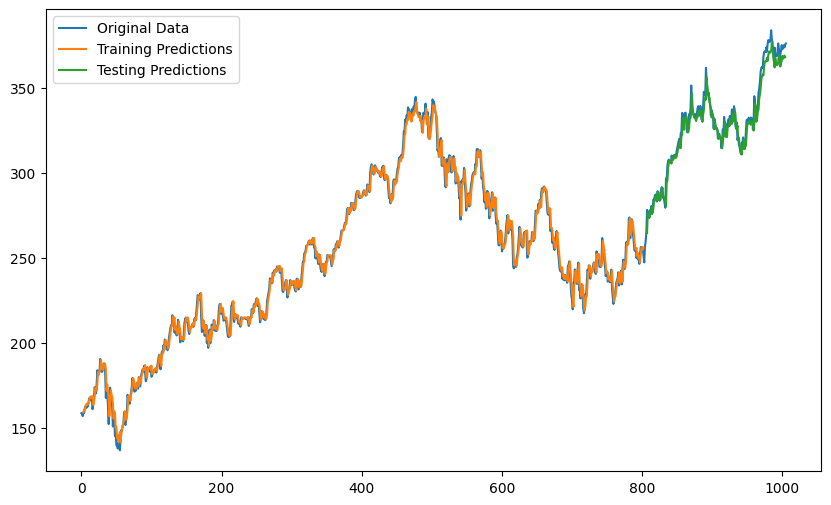

In [32]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(data_normalized)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data_normalized)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data_normalized)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(data_normalized), label='Original Data')
plt.plot(trainPredictPlot, label='Training Predictions')
plt.plot(testPredictPlot, label='Testing Predictions')
plt.legend()
plt